### Projeto Machine Learning II

O projeto deve ser feito em grupo e será apresentado dia 24/07.
Como o projeto será avaliado, o notebook deve conter:
1) Criar uma lista de dicas/técnicas
2) Indicar dentro do notebook cada item da lista(vide exemplo abaixo)

Esses dois itens são obrigatórios, caso contrário não serão aceitos.

### Lista de básica de itens  
A) Uso de um algoritmo de Machine Learning supervisionado e outro não supervisionado do módulo (Breve explicação do funcionamento)  
  
B) Uso da divisão do dataset train / test  
  
C) Uso de Feature Scaling  
  
D) Uso de técnicas de Categórico para Numérico
  
E) Uso de Feature Selection
  
F) Uso do Learning Curve / Analise under / overfiting
  
G) Nota sobre o balanceamento do dataset
  
H) Uso de métrica de avaliação, motivo da escolha
  
I) Uso de Pipeline
  
J) Uso da Otimização de Hiperparâmetros
  
K) Regularização
  
L) Nota de explicação dos hiperparâmetros utilizados
  
M) Uso do Cross Validation
  
N) Uso de mais de um agoritmo e comparação
  
O) ...

In [1]:
# Bibliotecas de manipulação de datasets
import pandas as pd
import numpy as np

#Bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de Machine Learning
# Divisão teste/treino, cross-validate
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

# Pre-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

# Pipeline/Column Transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
churn_train = pd.read_csv('customer_churn_dataset-training-master.csv')

churn_test = pd.read_csv('customer_churn_dataset-testing-master.csv')

churn_train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [3]:
print(churn_train.shape)
churn_train.info()

(440833, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [4]:
#Encontrei essa ferramenta abaixo, que é tipo um describe/info pra dataset, acho ela mais visual e fácil de analisar, mas precisa instalar.
#Caso alguém tenha interesse. pra instalar é só por: "pip install sumarytools" e depois "pip install Jinja2"

#from summarytools import dfSummary
#dfSummary(churn)


Temos 12 colunas sendo destas:
- 1 coluna Target ('Churn')
- 1 coluna de ID
- 3 colunas com informações categóricas
- 7 colunas com informações numéricas


In [5]:
#Customer ID pode ser removida
churn_train.drop(columns="CustomerID", inplace=True)

In [6]:
churn_train.isnull().sum()

Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

- Dataset com poucos valores nulos.

In [7]:
# Encontrando os valores nulos:
churn_train[churn_train.isnull().any(axis=1)]

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Os valores nulos estão concentrados todos em uma única linha, portanto esta será removida.

In [8]:
# No início haviam 440 883 linhas, no final é verificado que uma delas foi removida.
churn_train.dropna(inplace=True)
churn_train.shape[0]

440832

In [9]:
# Gender Male = 1, Female = 0
subscription = ['Basic', 'Standard', 'Premium']
# Subscription Basic = 0, Standard = 1, Premium = 2

contract = ['Monthly', 'Quarterly', 'Annual']
# contract = Monthly = 0, Quarterly = 1, Annual = 2


#Realizando o "scaling" dos dados numéricos
feat_num = churn_train.drop(columns='Churn').select_dtypes(include=np.number).columns
feat_cat = ['Gender']
feat_cat_ord = ['Subscription Type', 'Contract Length']
new_columns = list(feat_num) + feat_cat + feat_cat_ord + ['Churn']

preprocess = ColumnTransformer([
    ('std_scaler', StandardScaler(), feat_num),
    ('one_hot', OneHotEncoder(drop='first'), feat_cat),
    ('ord_code', OrdinalEncoder(categories=[subscription, contract]), feat_cat_ord)
], remainder='passthrough')

churn_scl_coded = preprocess.fit_transform(churn_train)

churn_scl_coded = pd.DataFrame(churn_scl_coded, columns=new_columns)

churn_scl_coded.head()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender,Subscription Type,Contract Length,Churn
0,-0.753326,0.448760,-0.210511,0.454549,0.609620,1.247427,0.293052,0.0,1.0,2.0,1.0
1,2.059646,1.028278,-1.724562,2.083100,-0.601319,-0.309865,-0.986584,0.0,0.0,0.0,1.0
2,1.255940,-1.000036,-1.375166,0.780259,0.609620,-1.854698,-1.335575,0.0,0.0,1.0,1.0
3,1.497051,0.390808,0.604748,1.105969,-0.722413,-0.978462,1.689018,1.0,1.0,0.0,1.0
4,-1.315921,0.043097,0.488282,0.454549,-0.601319,-0.060698,0.642043,1.0,0.0,0.0,1.0


In [10]:
churn_scl_coded.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender,Subscription Type,Contract Length,Churn
count,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,4.408320e+05,440832.000000,440832.000000,440832.000000,440832.000000
mean,7.994637e-17,1.779452e-17,-2.785228e-17,4.332578e-17,-3.094698e-18,-8.304107e-16,1.191459e-16,0.567681,1.012821,1.204373,0.567107
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.495399,0.813357,0.746851,0.495477
min,-1.717774e+00,-1.753410e+00,-1.724562e+00,-1.174002e+00,-1.570070e+00,-2.207684e+00,-1.568236e+00,0.000000,0.000000,0.000000,0.000000
25%,-8.336969e-01,-8.841327e-01,-7.928383e-01,-8.482914e-01,-8.435065e-01,-6.296283e-01,-8.702531e-01,0.000000,0.000000,1.000000,0.000000
50%,-2.999058e-02,4.309671e-02,2.242036e-02,-1.968711e-01,-1.169430e-01,1.220243e-01,-5.593961e-02,1.000000,1.000000,1.000000,1.000000
75%,6.933451e-01,8.544225e-01,8.376790e-01,7.802593e-01,7.307144e-01,8.238436e-01,8.747044e-01,1.000000,2.000000,2.000000,1.000000
max,2.059646e+00,1.665748e+00,1.652938e+00,2.083100e+00,2.062747e+00,1.529816e+00,1.805348e+00,1.000000,2.000000,2.000000,1.000000


In [11]:
# Amostra estratificada: pega 40% do dataset inicial
str_churn = churn_scl_coded.groupby('Churn', as_index=False).apply(lambda x: x.sample(frac=0.10))
str_churn20 = churn_scl_coded.groupby('Churn', as_index=False).apply(lambda x: x.sample(frac=0.20))
str_churn30 = churn_scl_coded.groupby('Churn', as_index=False).apply(lambda x: x.sample(frac=0.30))

print(str_churn.shape)
print(str_churn20.shape)
print(str_churn30.shape)

(44083, 11)
(88167, 11)
(132250, 11)


In [12]:
str_churn.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender,Subscription Type,Contract Length,Churn
count,44083.000000,44083.000000,44083.000000,44083.000000,44083.000000,44083.000000,44083.000000,44083.000000,44083.000000,44083.000000,44083.000000
mean,-0.009090,0.009891,-0.000168,0.000729,-0.002197,-0.000430,-0.004006,0.566568,1.004923,1.202278,0.567112
std,0.997755,1.002570,0.997233,0.998797,1.001079,1.001042,0.997082,0.495555,0.814910,0.748655,0.495481
min,-1.717774,-1.753410,-1.724562,-1.174002,-1.570070,-2.207684,-1.568236,0.000000,0.000000,0.000000,0.000000
25%,-0.833697,-0.884133,-0.792838,-0.848291,-0.843507,-0.621323,-0.870253,0.000000,0.000000,1.000000,0.000000
50%,-0.029991,0.043097,0.022420,-0.196871,-0.116943,0.122024,-0.055940,1.000000,1.000000,1.000000,1.000000
75%,0.693345,0.854422,0.837679,0.780259,0.730714,0.827996,0.874704,1.000000,2.000000,2.000000,1.000000
max,2.059646,1.665748,1.652938,2.083100,2.062747,1.529816,1.805348,1.000000,2.000000,2.000000,1.000000


In [13]:
# Fazer uma subsample do dataset e rodar todas as análises subsequentes, até o gridsearchcv/randomizedsearchcv

# OneHotEncoder - ok
# Scaler - ok
# Antes de fazer as análises exploratórias - fazer só no dataset training
# PCA
# CV com dataset com subsample 10%
# Rodar o modelo só com os dados completos com os parâmetros já tunados


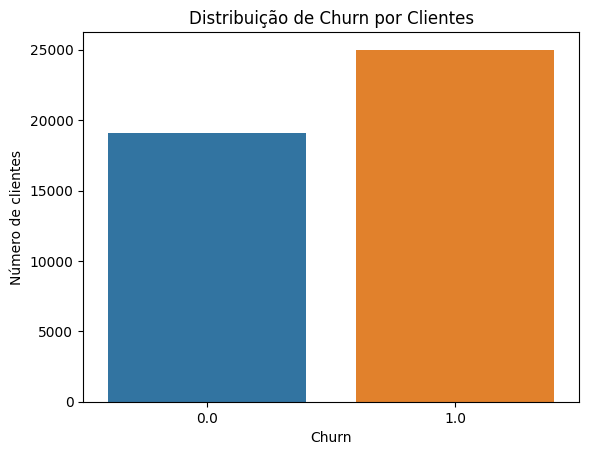

In [14]:
sns.countplot(data=str_churn, x='Churn')

#Pensar num título melhor
plt.title('Distribuição de Churn por Clientes')
plt.ylabel('Número de clientes')
plt.xlabel('Churn')
plt.show()

In [15]:
str_churn['Churn'].value_counts(normalize=True)

Churn
1.0    0.567112
0.0    0.432888
Name: proportion, dtype: float64

- Há um baixo desbalanceamento entre clientes com churn positivo e negativo.

#### Avaliando os clientes com churn positivo x negativo:

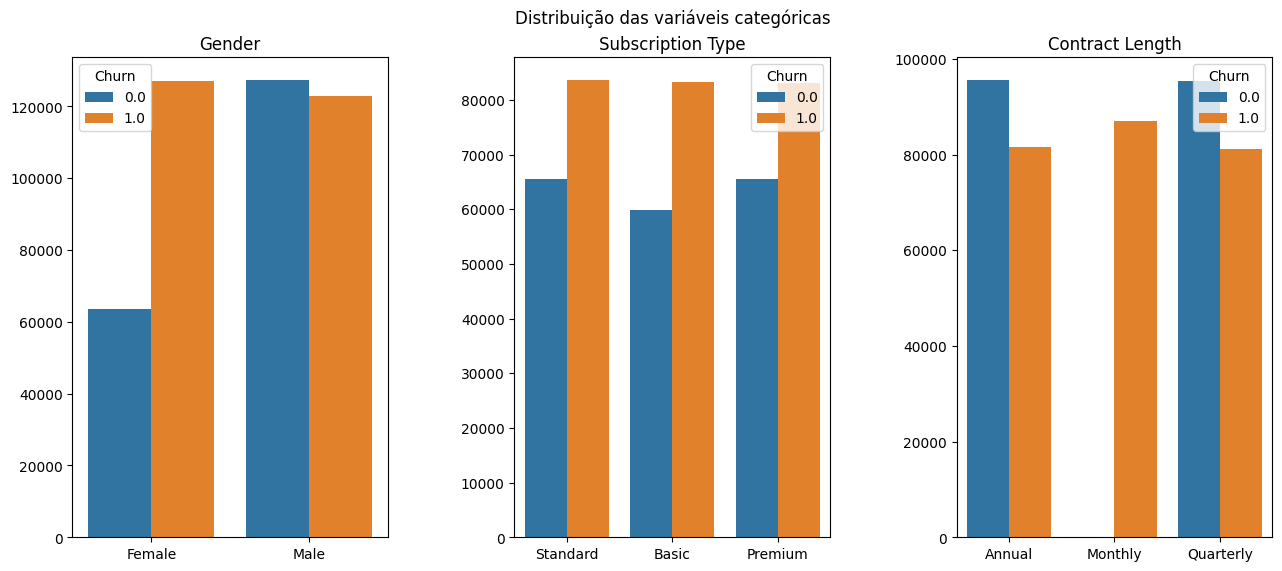

In [16]:
#Não rodar novamente, para manter os gráficos com título, legendas e labels da forma que estão.
category_list = ['Gender', 'Subscription Type', 'Contract Length']
count = 1

plt.subplots(1,3, figsize=(15,6))

for category in category_list:
    plt.subplot(1,3,count)
    sns.countplot(data=churn_train, x=category, hue='Churn')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(category)
    count += 1
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    
plt.suptitle('Distribuição das variáveis categóricas')
plt.show()

- Há uma diferença expressiva entre churns positivos e negativos para clientes do sexo feminino.
- Não há clientes de churn negativo que apresentem tempo de contrato mensal (deve afetar o modelo, pois pelo que lembro, no dataset de treino há um bom valor nesse campo *[rever]* ).

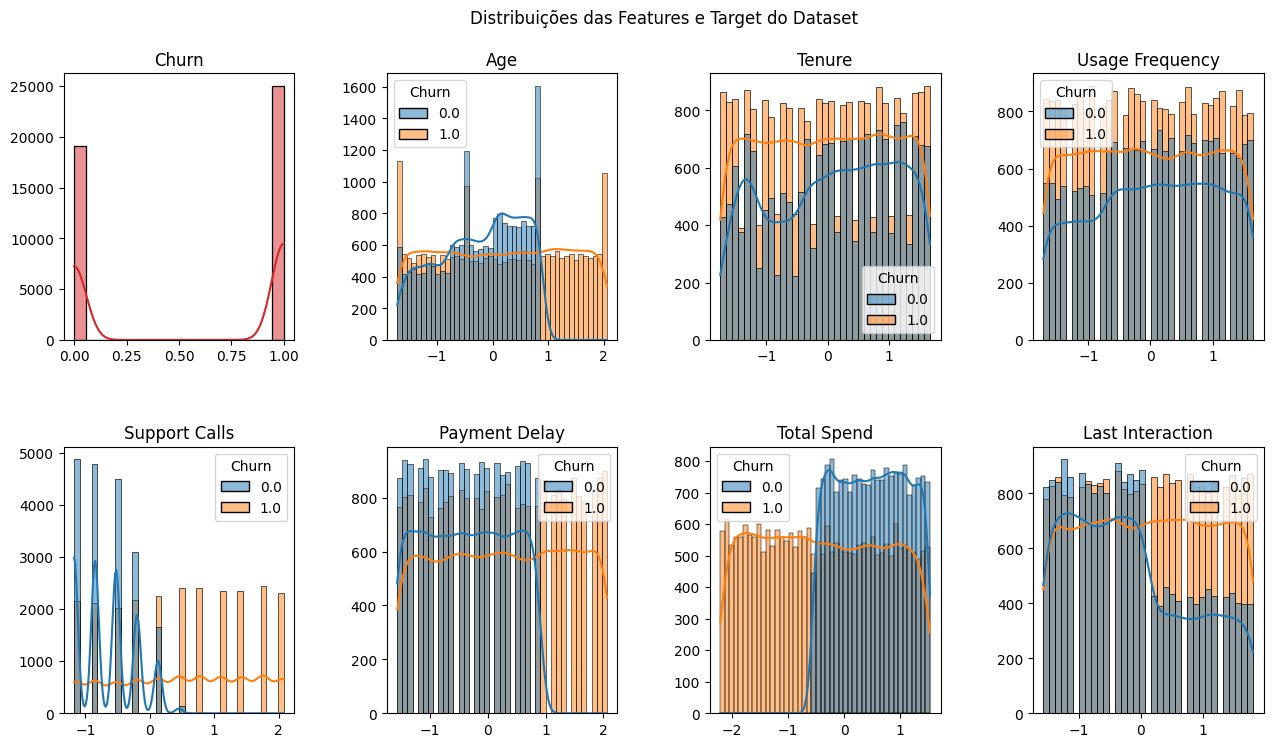

In [17]:
feature_names = ['Churn', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']

fig = plt.figure(figsize=(15,8))

for number, category in enumerate(feature_names, start=1):
    if category == 'Churn':
        ax = fig.add_subplot(2,4,number)
        sns.histplot(data=str_churn, x=category, kde=True, color='tab:red')
        plt.title(category)
        ax.set_ylabel('')
        ax.set_xlabel('')
    else:
        ax = fig.add_subplot(2, 4,number)
        sns.histplot(data=str_churn, x=category, hue='Churn', kde=True)
        plt.title(category)
        ax.set_ylabel('')
        ax.set_xlabel('')      

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.suptitle('Distribuições das Features e Target do Dataset')
plt.show()

- Nenhuma distribuição segue a curva Normal
- Várias se aproximam de uma distribuição uniforme

- Distribuições das variáveis tem tendências contrárias quando separadas por Churn positivo ou negativo

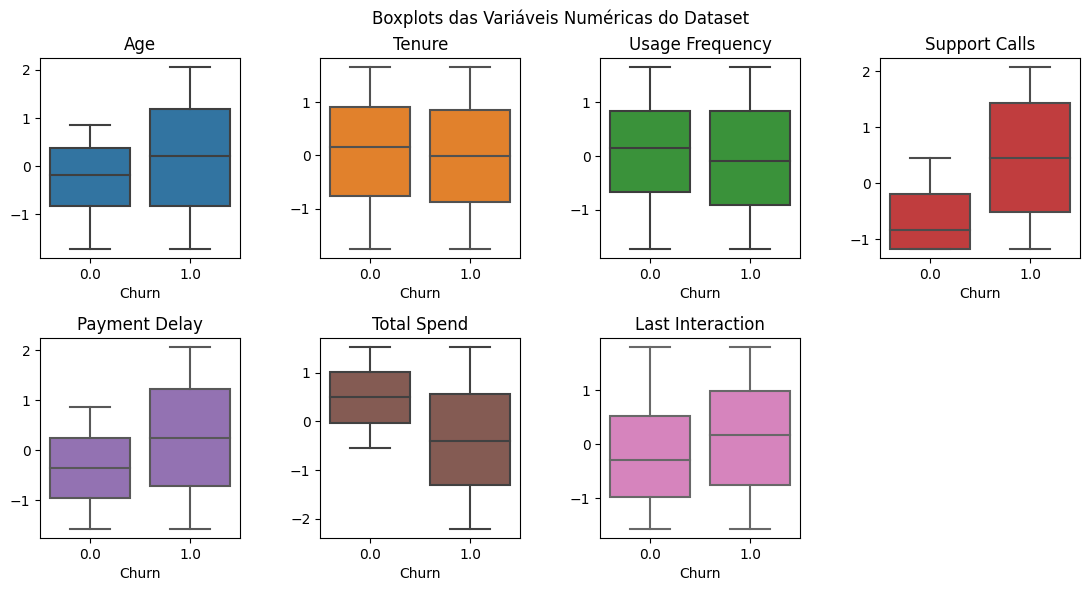

In [18]:
# Boxplot das features
numeric_list = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
colors = {1:'tab:blue', 2:'tab:orange', 3:'tab:green', 4:'tab:red', 5:'tab:purple', 6:'tab:brown', 7: 'tab:pink'}

fig= plt.figure(figsize=(13,6))

for number, category in enumerate(numeric_list, start=1):
    ax = fig.add_subplot(2,4,number)
    sns.boxplot(data=str_churn, y=category, x='Churn', color=colors[number])
    plt.title(category)
    plt.xlabel('Churn')
    ax.set_ylabel('')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

plt.suptitle('Boxplots das Variáveis Numéricas do Dataset')
plt.show()

- Distribuições de ```Age, Support Calls, Payment Delay e Total Spend``` possuem diferenças entre churns negativo e positivo.
- ```Suport Cals e Payment Delay``` com Churn negativo apresentam mediana e quartis mais baixos, ou seja, necessitaram menos do suporte e atrasaram menos seus pagamentos. 
- ```Total Spend``` apresenta o oposto, para o o Churn negativo a mediana e quartis são maiores, ou seja, estes clientes gastam um valor maior.
- Para as coluna ```Age e Last Interaction```, aparenta ter maior amplitude no intervalo interquartil de churn positivo que o observado para churn negativo.
- Este dataset não apresenta **outliers em nenhuma feature**.

In [19]:
str_churn.head()

Age    Tenure  Usage Frequency  Support Calls  Payment Delay  \
0 337954 -0.592585 -1.637507        -0.792838      -1.174002      -0.238037   
  435748 -0.672956  1.260085         1.536472      -1.174002      -1.448976   
  414090 -1.637403  0.506711         1.070610      -1.174002       0.004151   
  326083 -0.271102 -1.463651         1.070610      -0.522581      -0.480225   
  419050 -1.717774 -0.478470         0.604748      -0.848291      -1.206788   

          Total Spend  Last Interaction  Gender  Subscription Type  \
0 337954     1.266280         -1.335575     0.0                1.0   
  435748     0.735140         -1.568236     0.0                0.0   
  414090     0.307903         -0.521262     1.0                0.0   
  326083     1.431063         -1.451906     0.0                2.0   
  419050    -0.480045         -1.451906     1.0                1.0   

          Contract Length  Churn  
0 337954              2.0    0.0  
  435748              1.0    0.0  
  414090              1.0    0.0  
  326083              2.0    0.0  
  419050              2.0    0.0

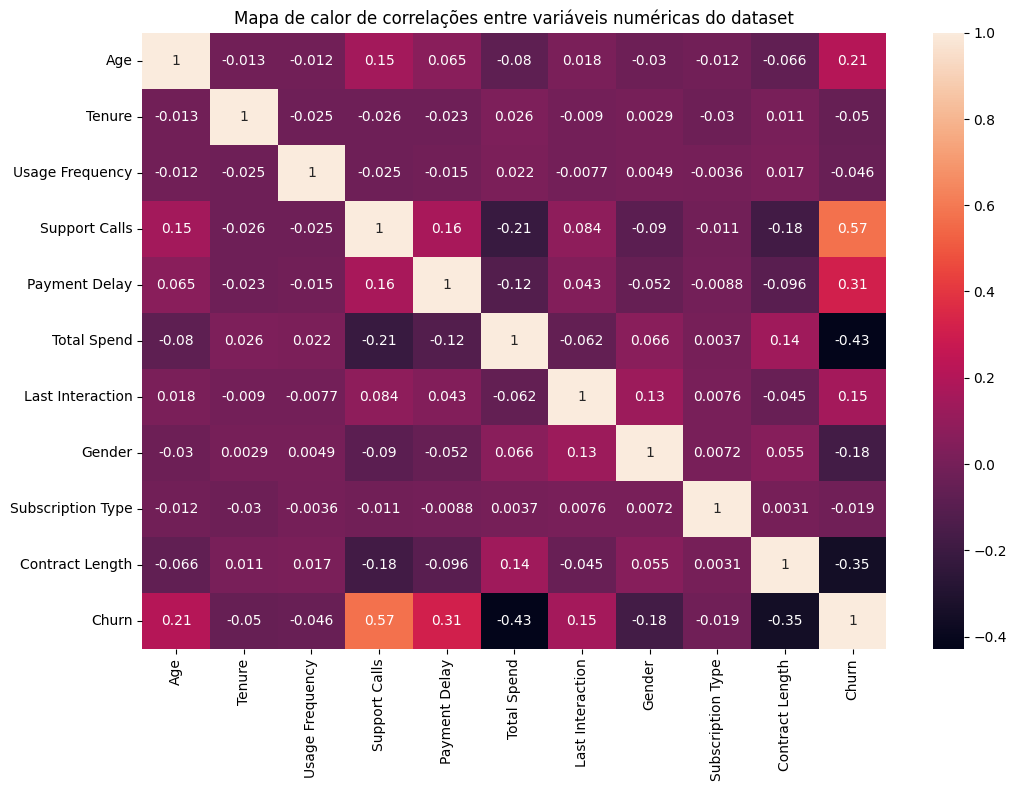

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(str_churn.corr(numeric_only=True), annot=True)
plt.title('Mapa de calor de correlações entre variáveis numéricas do dataset')
plt.show()

- As features que mais se destacam em correlação com o target são: ```Support Calls, Payment Delay, Total Spend, Contract Length```, seguidas por ```Age, Last Interaction, Gender```.
- Além destas, ```Support Calls, Payment Delay, Total Spend```, duas a duas, apresentam certas correlações entre si (variando de -0.22 a 0.16).

In [21]:
# Repensar o plot do pairplot.
# Como tem mais observações 'Churn' = 1.0, devido a sobreposição, os dados 'Churn' = 0.0 não aparecem, acredito que estão embaixo.
# sns.pairplot(data=str_churn, hue='Churn')

- Padrões interessantes, em algumas features parece que o SVM se daria muito bem. Em algumas aparece tipo um L, que me lembra muito o AdaBoost/XGBoost. Observando as curvas kde, deve ter bastante sobreposição também.

### Machine Learning

Baseado no que vimos nesse módulo, o que acredito que seria bacana fazer:
- PCA *(p/ diminuir dimensionalidade)*
- Regressão Logística
- XGBoost *Classifier*
- Suport Vector Machine *Classifier*

#### PCA
**Objetivo:** Diminuir dimensionalidade

In [22]:
#Removendo a coluna de target
X_train = str_churn.drop(columns='Churn')

#### PCA: 2 componentes

In [23]:
# Apesar de juntos, PC1 e PC2, representarem apenas 30% da variância dos dados, tentei rodar abaixo a distribuição.
pca_2 = PCA(n_components=2,random_state=42)
pca_2.fit(X_train)

PCA(n_components=2, random_state=42)

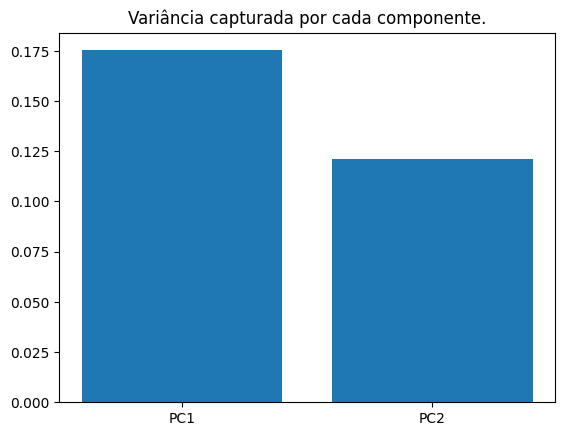

In [24]:
labels = [f'PC{i+1}' for i in range(pca_2.n_components_)]
plt.bar(labels, pca_2.explained_variance_ratio_)
plt.title("Variância capturada por cada componente.")
plt.show()

In [25]:
# Transforma as features do dataset de treino nas features do PCA
X_train_pca_2 = pca_2.transform(X_train)

In [26]:
# Cria um dataset temporário, cópia do original, mas sem os índices, 
# caso contrário não é possível pegar a coluna de "Chrun" para o novo dataset abaixo.
str_churn_temp = str_churn.reset_index(drop=True)

# Cria um dataframe, onde agora as features são os dois PCs do modelo "pca_2"
X_train_pca_2 = pd.DataFrame(X_train_pca_2, columns=['PC1','PC2'])

# Adiciona neste novo dataframe, os dados de "Churn"
X_train_pca_2['Churn'] = str_churn_temp['Churn']
X_train_pca_2.head()

,PC1,PC2,Churn
0,-1.844761,-0.826231,0.0
1,-2.410134,0.023820,0.0
2,-1.608093,-0.330302,0.0
3,-1.740515,-1.887486,0.0
4,-1.867578,-0.817492,0.0


<Axes: xlabel='PC1', ylabel='PC2'>

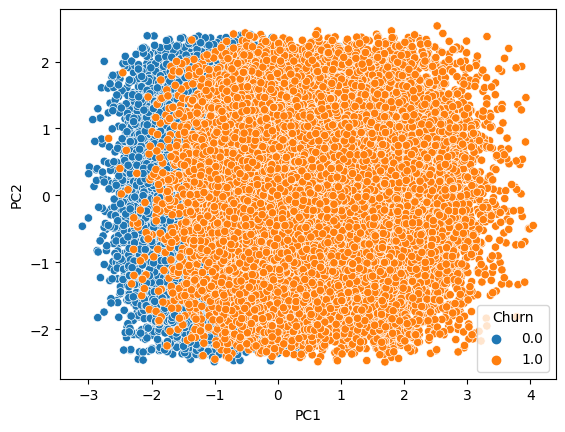

In [28]:
sns.scatterplot(data=X_train_pca_2, x="PC1", y="PC2", hue="Churn")

Mesmo com os componentes PC1 e PC2 representando 30% da variância dos dados, ao utilizar apenas estes componentes é possível notar um padrão/segregação.

#### PCA Completo

In [29]:
#Criando o modelo de PCA e fazendo fit com nossos dados de treino
pca = PCA(random_state=42)
pca.fit(X_train)

PCA(random_state=42)

In [30]:
# Variância capturada por cada componente
pca.explained_variance_ratio_

array([0.17530039, 0.12122499, 0.11646414, 0.11455848, 0.11030489,
       0.10460433, 0.09054853, 0.0781909 , 0.0609948 , 0.02780853])

- O primeiro componente explica cerca 17.5% da variância nos dados.
- Cada um dos componentes 2 a 6, explica, em média 11%, a variância dos dados.
- Os componentes 7 a 9, explicam aprox.: 9%, 8% e 6%, respectivamente.
- O décimo componente explica apenas 2.8% da variância dos dados.

In [31]:
#print(pca.components_)
print(pca.feature_names_in_)

['Age' 'Tenure' 'Usage Frequency' 'Support Calls' 'Payment Delay'
 'Total Spend' 'Last Interaction' 'Gender' 'Subscription Type'
 'Contract Length']


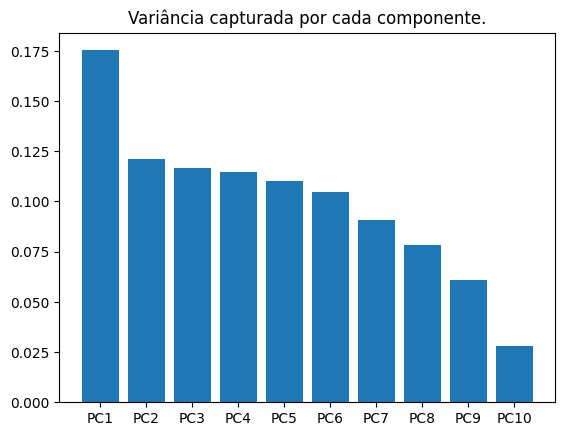

In [32]:
labels = [f'PC{i+1}' for i in range(pca.n_components_)]
plt.bar(labels, pca.explained_variance_ratio_)
plt.title("Variância capturada por cada componente.")
plt.show()

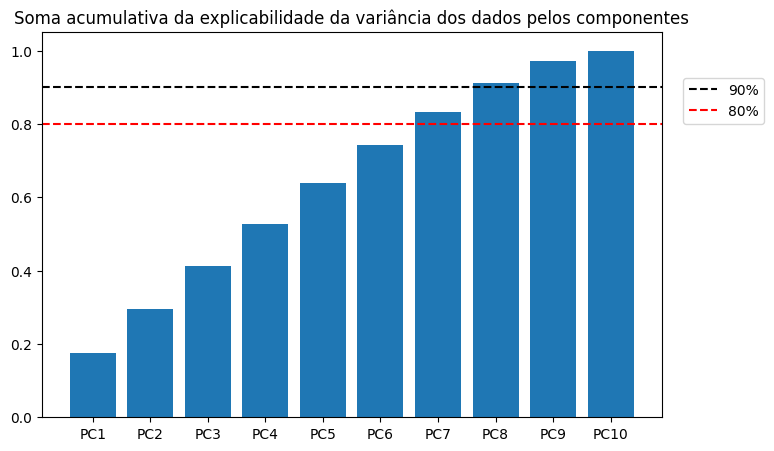

In [33]:
# Utilizando o modelo com os 10 componentes do PCA
plt.figure(figsize=(8,5))
labels = [f'PC{i+1}' for i in range(pca.n_components_)]
plt.bar(labels, pca.explained_variance_ratio_.cumsum())
plt.axhline(y=0.9, color='k', linestyle= '--', label="90%")
plt.axhline(y=0.8, color='r', linestyle= '--', label="80%")
plt.legend(bbox_to_anchor = (1.1, 0.9), loc = 'upper center')
plt.title("Soma acumulativa da explicabilidade da variância dos dados pelos componentes")
plt.show()

In [36]:
print("Soma acumulativa da explicabilidade dos componentes: \n")
for soma in enumerate(pca.explained_variance_ratio_.cumsum()):
    print(f"Até o {soma[0]+1}º = {round(soma[1]*100,1)} %")

Soma acumulativa da explicabilidade dos componentes: 

Até o 1º = 17.5 %
Até o 2º = 29.7 %
Até o 3º = 41.3 %
Até o 4º = 52.8 %
Até o 5º = 63.8 %
Até o 6º = 74.2 %
Até o 7º = 83.3 %
Até o 8º = 91.1 %
Até o 9º = 97.2 %
Até o 10º = 100.0 %


```Comentário de explicação (remover posteriormente):```

Como no PCA as features viram nossos componentes (que são a combinação das features originais), acabamos perdendo um pouco da explicabilidade do modelo, além de que a variancia dos dados não é altamente representada por poucos componentes. 

Já que não temos tantas features, acredito que nem seria tão essencial usar o PCA, mas quem sabe seja necessário pelo critério de apresentar algo que envolvia aprendizagem não-supervisionada.

Uma ideia que me surgiu foi: caso haja tempo, depois rodar o modelo sem o PCA, pra ver se tem uma mlehora nas métricas.

#### DATASET APÓS PCA

Neste caso, analisando os gráficos acima, poderíamos decicidir em usar apenas os 7 ou 8 primeiros componentes. 

In [35]:
# Decidir se será usado 7 ou 8 componentes e então rodar essa célula.

# Cria e fita o PCA
pca_final = PCA(n_components = 8, random_state=42)
pca_final.fit(X_train)

# Transforma as features do dataset de treino nas features do PCA
X_train_pca = pca_final.transform(X_train)

# Cria um dataframe, onde agora as features são o componentes do pca_final
labels_pca_final = [f"PC{i+1}" for i in range(pca_final.n_components_)]
X_train_pca = pd.DataFrame(X_train_pca, columns=labels_pca_final)

# Adiciona neste novo dataframe, os dados de "Churn"
X_train_pca['Churn'] = str_churn_temp['Churn']
X_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Churn
0,-1.844761,-0.826231,-0.876939,1.939804,0.217004,0.562508,-0.018929,-0.147806,0.0
1,-2.410134,0.023820,-1.130565,-1.649379,0.351854,-0.871730,-0.159506,-0.899903,0.0
2,-1.608093,-0.330302,0.258654,-0.836997,1.441231,-0.161249,0.241930,-0.988956,0.0
3,-1.740515,-1.887486,-1.187547,0.401316,0.010760,0.382598,-0.581733,0.913394,0.0
4,-1.867578,-0.817492,-0.401043,0.299491,1.111572,-1.627585,0.127557,-0.078483,0.0
